In [1]:
import pandas as pd
import numpy as np

file_path = 'GSE295766_All.FPKM.xls'
df = pd.read_excel(file_path, engine='xlrd')

fpkm_columns = ['T1.FPKM', 'T2.FPKM', 'TO1.FPKM', 'TO2.FPKM']

for col in fpkm_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

display(df.head())

,GeneSymbol,T1.FPKM,T2.FPKM,TO1.FPKM,TO2.FPKM
0,ENSG00000105835,61.18,49.11,3906.822354,3711.481237
1,ENSG00000173614,2.74,2.46,14.763158,14.025000
2,ENSG00000096717,17.64,16.07,50.917290,48.371425
3,ENSG00000170345,0.23,0.74,3.872207,3.678597
4,ENSG00000122512,3.65,5.27,0.009838,0.009346


In [2]:
from scipy.stats import ttest_ind

control_replicates = ['T1.FPKM', 'T2.FPKM']
resistant_replicates = ['TO1.FPKM', 'TO2.FPKM']

df['Control_Avg_FPKM'] = df[control_replicates].mean(axis=1)
df['Resistant_Avg_FPKM'] = df[resistant_replicates].mean(axis=1)

filtered_df = df[(df['Control_Avg_FPKM'] > 1) | (df['Resistant_Avg_FPKM'] > 1)].copy()

stats, p_values = ttest_ind(
    filtered_df[control_replicates],
    filtered_df[resistant_replicates],
    axis=1,
    equal_var=False
)
filtered_df['p_value'] = p_values

pseudocount = 1
filtered_df['log2FoldChange'] = np.log2(
    (filtered_df['Resistant_Avg_FPKM'] + pseudocount) / (filtered_df['Control_Avg_FPKM'] + pseudocount)
)

filtered_df['significance'] = 'Not Significant'
filtered_df.loc[(filtered_df['log2FoldChange'] > 1) & (filtered_df['p_value'] < 0.05), 'significance'] = 'Upregulated'
filtered_df.loc[(filtered_df['log2FoldChange'] < -1) & (filtered_df['p_value'] < 0.05), 'significance'] = 'Downregulated'

upregulated_count = len(filtered_df[filtered_df['significance'] == 'Upregulated'])
downregulated_count = len(filtered_df[filtered_df['significance'] == 'Downregulated'])

print(f"Total Significantly Upregulated Genes: {upregulated_count}")
print(f"Total Significantly Downregulated Genes: {downregulated_count}")

Total Significantly Upregulated Genes: 263
Total Significantly Downregulated Genes: 403


/opt/homebrew/Cellar/jupyterlab/4.4.5/libexec/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:611: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


/opt/homebrew/Cellar/jupyterlab/4.4.5/libexec/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


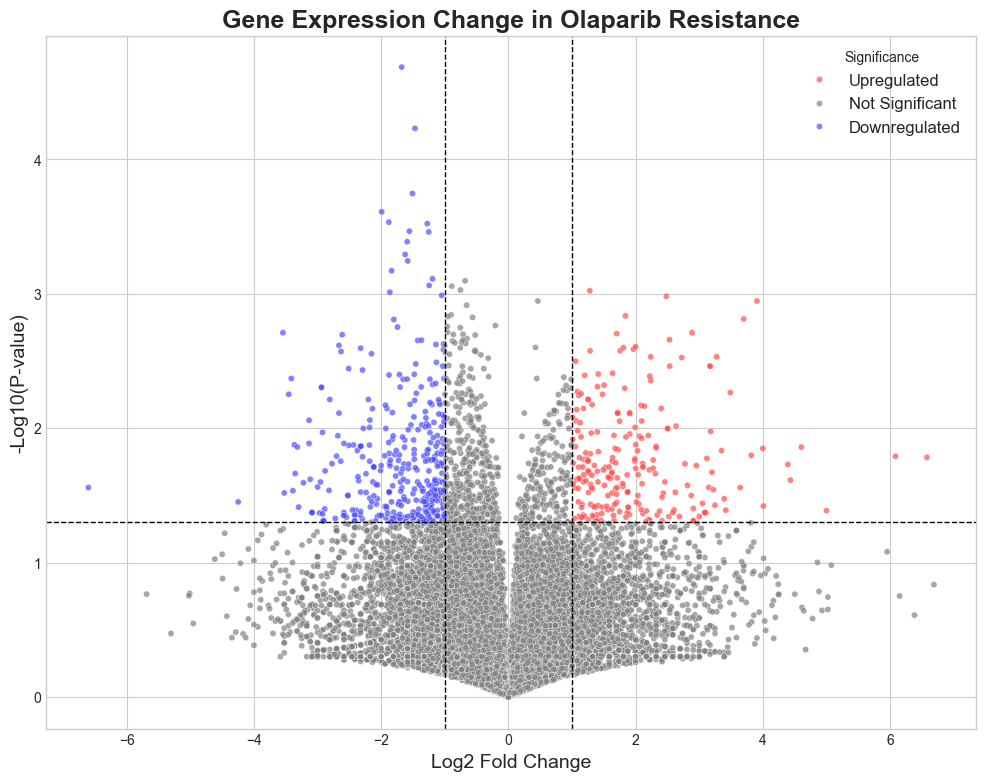

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Create Volcano Plot ---
filtered_df['-log10_p_value'] = -np.log10(filtered_df['p_value'].fillna(1))
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 9))
sns.scatterplot(
    data=filtered_df, x='log2FoldChange', y='-log10_p_value', hue='significance',
    palette={'Upregulated': '#ff4d4d', 'Downregulated': '#4d4dff', 'Not Significant': 'grey'},
    alpha=0.7, s=20
)
plt.axhline(y=-np.log10(0.05), color='black', linestyle='--', linewidth=1)
plt.axvline(x=1, color='black', linestyle='--', linewidth=1)
plt.axvline(x=-1, color='black', linestyle='--', linewidth=1)
plt.title('Gene Expression Change in Olaparib Resistance', fontsize=18, weight='bold')
plt.xlabel('Log2 Fold Change', fontsize=14)
plt.ylabel('-Log10(P-value)', fontsize=14)
plt.legend(title='Significance', fontsize='large')
plt.savefig('volcano_plot_final.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Create and Save Upregulated Table Image ---
top_10_upregulated = filtered_df.sort_values(by='log2FoldChange', ascending=False).head(10).round(2)
fig, ax = plt.subplots(figsize=(16, 4))
ax.axis('tight'); ax.axis('off')
the_table_up = ax.table(cellText=top_10_upregulated.values, colLabels=top_10_upregulated.columns, loc='center', cellLoc='center')
the_table_up.auto_set_font_size(False); the_table_up.set_fontsize(10); the_table_up.scale(1.2, 1.2)
plt.savefig('top_10_upregulated_genes.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.close()

# --- Create and Save Downregulated Table Image ---
top_10_downregulated = filtered_df.sort_values(by='log2FoldChange', ascending=True).head(10).round(2)
fig, ax = plt.subplots(figsize=(16, 4))
ax.axis('tight'); ax.axis('off')
the_table_down = ax.table(cellText=top_10_downregulated.values, colLabels=top_10_downregulated.columns, loc='center', cellLoc='center')
the_table_down.auto_set_font_size(False); the_table_down.set_fontsize(10); the_table_down.scale(1.2, 1.2)
plt.savefig('top_10_downregulated_genes.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.close()

--- Displaying Saved Table Images ---

Top 10 Upregulated Genes:


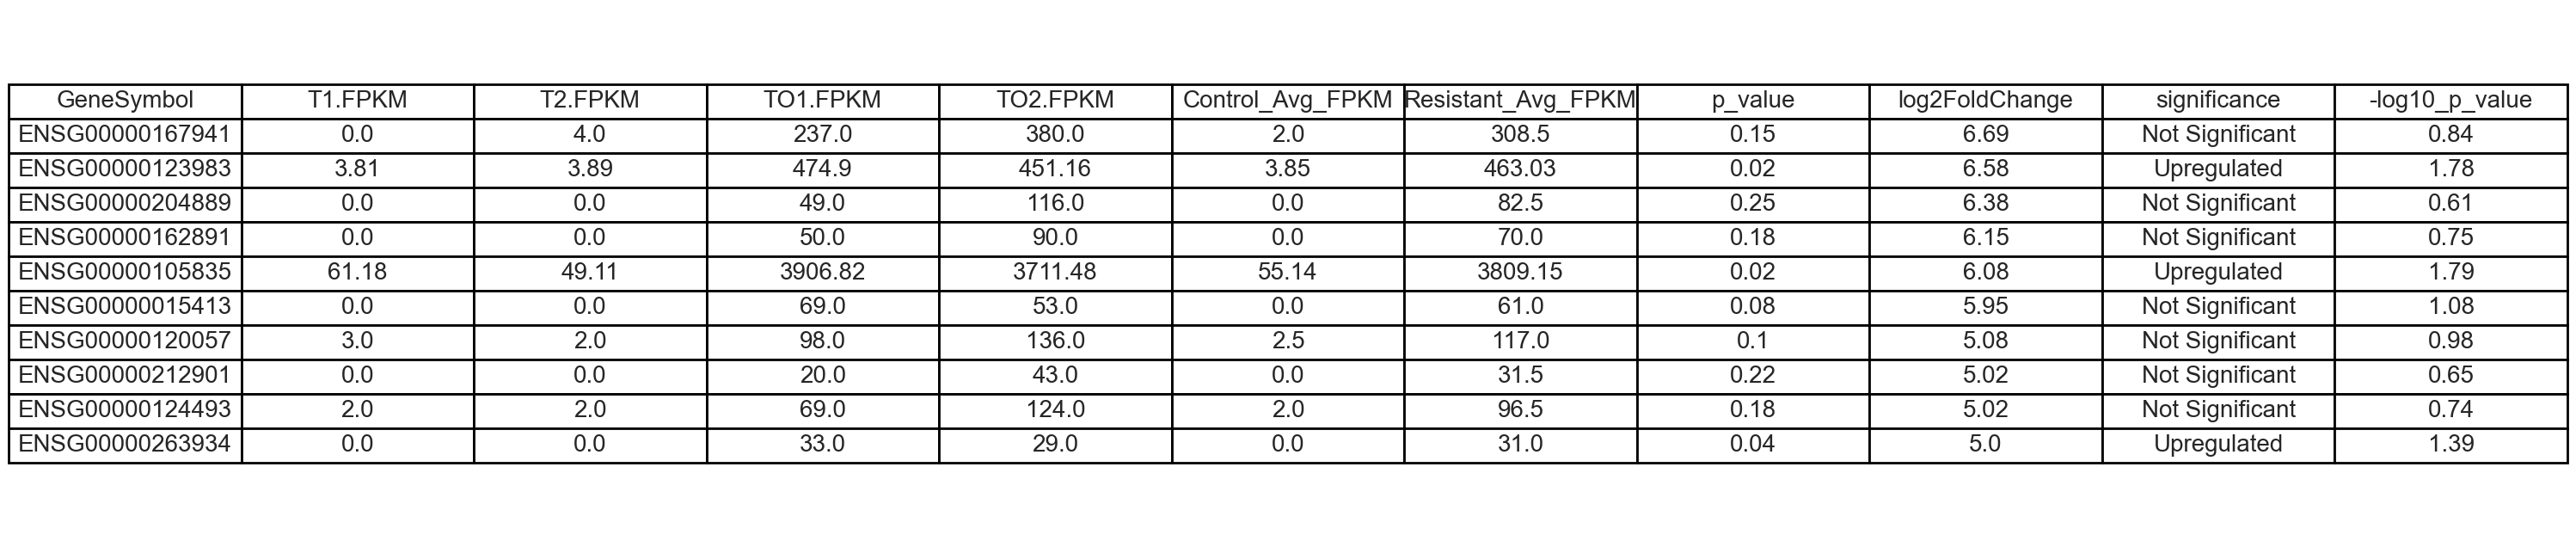


Top 10 Downregulated Genes:


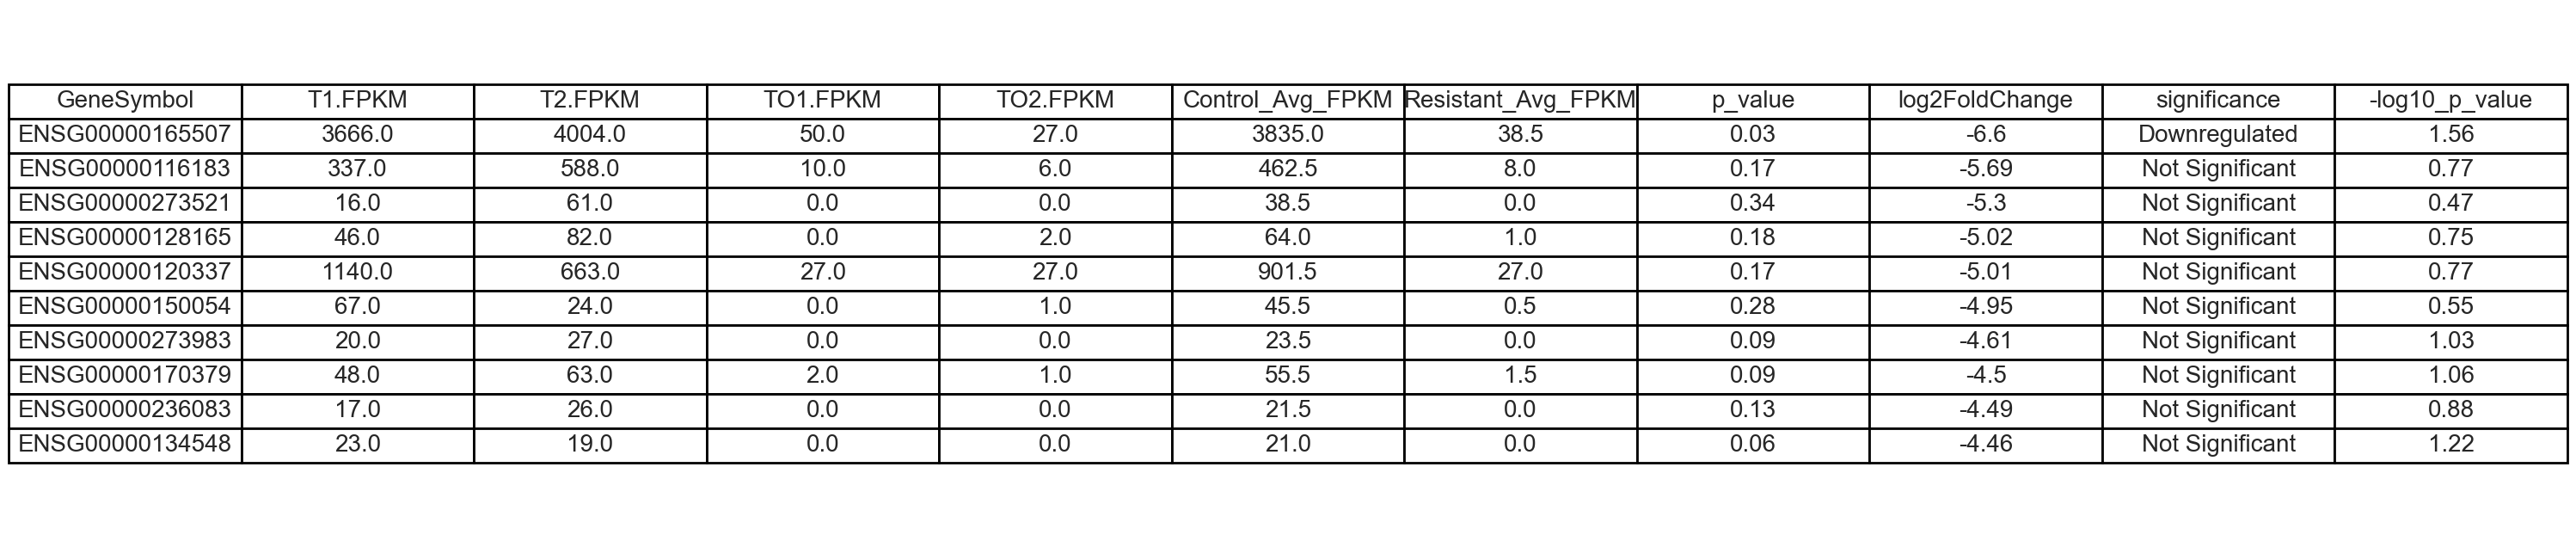

In [5]:
from IPython.display import Image, display

print("--- Displaying Saved Table Images ---")

print("\nTop 10 Upregulated Genes:")
display(Image(filename='top_10_upregulated_genes.png'))

print("\nTop 10 Downregulated Genes:")
display(Image(filename='top_10_downregulated_genes.png'))